In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as col
import matplotlib.cm as cm
import json
import os
import numpy as np
from tqdm import tqdm

create_coda_root = f'/fzi/ids/ju878/model_contradictions/create_coda/'
coda_root = f'/disk/ml/own_datasets/CODA/'
log_finn_root = f'/disk/vanishing_data/ju878/log_finn/'
lidar_annotation_folder = os.path.join(coda_root, 'lidar_annotation')
lidar_labels = os.path.join(coda_root, 'lidar_labels_annotation')
annotation_validation = os.path.join(create_coda_root, 'annotation_validation')
json_cornercases = os.path.join(coda_root, 'corner_case.json')
original_labels = os.path.join(log_finn_root, 'original_labels_annotation')

if not os.path.exists(original_labels):
    os.makedirs(original_labels)

with open(annotation_validation, 'r') as f:
    anno_valid = f.read().splitlines()
    
with open(json_cornercases, 'r') as f:
    data_cornercases = json.load(f)
    
categories = data_cornercases['categories']
images = data_cornercases['images']
annotations = data_cornercases['annotations']


In [3]:
image_id = 0
show = False

In [4]:
def save_points(points_kitti, points, image_id):
    points_kitti.astype('float32').tofile(os.path.join(original_labels, image_id + '.bin'))
    points.astype('float32').tofile(os.path.join(lidar_labels, image_id + '.bin'))

In [5]:
def rotate_nuscenes(points):
    new_points = np.zeros_like(points)
    new_points[:, 1] = -points[:, 0]
    new_points[:, 0] = points[:, 1]
    new_points[:, 2] = points[:, 2]
    
    return new_points[:, :3]
    
def rotate_once(points):
    new_points = np.zeros_like(points)
    new_points[:, 1] = points[:, 0]
    new_points[:, 0] = -points[:, 1]
    new_points[:, 2] = points[:, 2]
    
    return new_points[:, :3]

In [6]:
def get_lidar_with_labels(annotation):
    annotation_id = annotation['id']
    annotation_path = os.path.join(lidar_annotation_folder, str(annotation_id) + '.bin')
    clustering = anno_valid[annotation_id - 1]
    
    points = np.fromfile(annotation_path, dtype=np.float32).reshape((-1, 7))
     
    return points, clustering
    
def set_labels(points, clustering):
    labels = np.ones((points.shape[0], 1))
    if clustering == 1:
        labels[:, 0] = points[:, 4]
    elif clustering == 2:
        labels[:, 0] = points[:, 6]
    elif clustering == 3:
        labels[:, 0] = points[:, 4]
    elif clustering == 4:
        for index, point in enumerate(points):
            if point[4] == 1 or point[6] == 1:
                labels[index, 0] = 1
            else:
                labels[index, 0] = -1
    elif clustering == 5:
        labels[:, 0] = -points[:, 4]
    elif clustering == 6:
        labels = labels
    elif clustering == 7:
        labels = labels
    elif clustering == 8:
        labels[:, 0] = -points[:, 6]
    elif clustering == 9:
        labels = labels
    return np.hstack([points[:, :3], labels])

def handle_dublicates(annotations_in_lidar):
    unique_rows, indices = np.unique(annotations_in_lidar, axis=0, return_index=True)
    annotations_in_lidar_unique = annotations_in_lidar[np.sort(indices)]
    for index, annotation_1 in enumerate(annotations_in_lidar_unique):
        if annotation_1[3] == 1:
            continue
        else:
            for annotation_2 in annotations_in_lidar:
                if annotation_1[0] == annotation_2[0] and annotation_1[1] == annotation_2[1] and annotation_1[2] == annotation_2[2] and annotation_2[3] == 1: # and annotations_in_lidar[index, 1] == point[1] and annotations_in_lidar[index, 2] == point[2]:
                    annotations_in_lidar_unique[index, 3] == 1
    return annotations_in_lidar_unique
    

In [7]:
def plot_scatter(annotations_in_lidar):
    x, y, z, label = annotations_in_lidar.T
    fig = plt.figure(figsize=(3,3), dpi=200)
    ax = fig.add_subplot(projection='3d')
    np_color = get_normalized_colors(label)
    ax.scatter([-y],[x],[z], c=np_color[:,:3], alpha=1, s=0.8)
    plt.show()
    plt.close()
    
def get_normalized_colors(color):
    cmap = cm.get_cmap('jet')
    norm = col.Normalize(vmin=np.min(color), vmax=np.max(color))
    np_colors = [cmap(norm(c)) for c in color]
    np_color = np.asarray(np_colors)
    return np_color

In [ ]:
for image in tqdm(images):
    if image['id'] >= image_id:
        id = image['id']
        print(id)
        file_name = image['file_name'].split('.')[0]
        prefix, name = file_name.split('_')
        annotations_in_image = []
        annotations_in_lidar = np.array([-1,-1,-1,-1])
        
        
        for annotation in annotations:
            if(annotation['image_id']) == id:
                annotations_in_image.append(annotation)
                #break
        
        
        if prefix == 'kitti':
            for annotation in annotations_in_image:
                points, clustering = get_lidar_with_labels(annotation)
                points = set_labels(points, int(clustering))
                annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar = handle_dublicates(annotations_in_lidar)
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
            
        elif prefix == 'nuscenes':
            for annotation in annotations_in_image:
                points, clustering = get_lidar_with_labels(annotation)
                points = set_labels(points, int(clustering))
                annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar = handle_dublicates(annotations_in_lidar)
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            annotations_in_lidar_kitti[:, :3] = rotate_nuscenes(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
        else:
            for annotation in annotations_in_image:
                points, clustering = get_lidar_with_labels(annotation)
                points = set_labels(points, int(clustering))
                annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar = handle_dublicates(annotations_in_lidar)
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            annotations_in_lidar_kitti[:, :3] = rotate_once(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
        
        if show:
            plot_scatter(annotations_in_lidar)
            plot_scatter(annotations_in_lidar_kitti)
         

In [13]:
for annotation in tqdm(annotations):
        id = annotation['id']
        annotations_in_lidar = np.array([-1,-1,-1,-1])
        
        
        
        if id > 4413 and id <= 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
            
        elif id > 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            annotations_in_lidar_kitti[:, :3] = rotate_nuscenes(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
        elif id <= 4413:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            annotations_in_lidar = np.vstack([annotations_in_lidar, points])
            annotations_in_lidar_kitti = np.copy(annotations_in_lidar)
            annotations_in_lidar_kitti[:, :3] = rotate_once(annotations_in_lidar)
            save_points(annotations_in_lidar_kitti, annotations_in_lidar, '{0:04d}'.format(int(id)))
        
        
        if show:
            plot_scatter(annotations_in_lidar)
            plot_scatter(annotations_in_lidar_kitti)

         

100%|██████████| 5937/5937 [00:02<00:00, 2600.41it/s]

55.711080897348744
314.08020050125316
30.884341637010674
100.98005891683663
717.1578947368421
40.75177935943061
0.6444528965491311
0.6954338654171447
0.5688719432680486


100%|██████████| 5937/5937 [00:02<00:00, 2124.89it/s]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
<ipython-input-82-e6ecd1a45355>:76: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(bottom=0, top=2000)


55.711080897348744
314.08020050125316
30.85688888888889
100.98005891683663
717.1578947368421
40.715555555555554
28
297
6
0.644452896549131
0.6954338654171446
0.5688719432680486


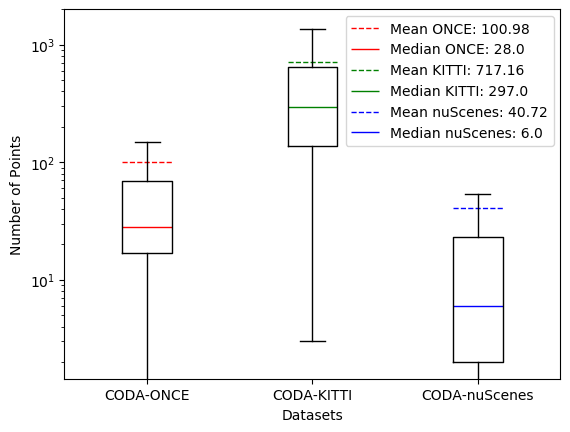

In [82]:
once_anno_sum = []
kitti_anno_sum = []
nuscenes_anno_sum = []
once_sum = []
kitti_sum = []
nuscenes_sum = []

for annotation in tqdm(annotations):
        id = annotation['id']
        annotations_in_lidar = np.array([-1,-1,-1,-1])
        
        
        
        if id > 4413 and id <= 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            kitti_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            kitti_sum.append(len(np.where(points[:, 3] == -1)[0]))
            
        elif id > 4812:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            nuscenes_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            nuscenes_sum.append(len(np.where(points[:, 3] == -1)[0]))
        elif id <= 4413:
            points, clustering = get_lidar_with_labels(annotation)
            points = set_labels(points, int(clustering))
            once_anno_sum.append(len(np.where(points[:, 3] == 1)[0]))
            once_sum.append(len(np.where(points[:, 3] == -1)[0]))

#once_anno_sum /= 4413
#kitti_anno_sum /= 399
#nuscenes_anno_sum /= 1124
#
#once_sum /= 4413
#kitti_sum /= 399
#nuscenes_sum /= 1124
once_sum = sorted(once_sum, reverse=True)
kitti_sum = sorted(kitti_sum, reverse=True)
nuscenes_sum = sorted(nuscenes_sum, reverse=True)
once_anno_sum = sorted(once_anno_sum, reverse=True)
kitti_anno_sum = sorted(kitti_anno_sum, reverse=True)
nuscenes_anno_sum = sorted(nuscenes_anno_sum, reverse=True)


print(sum(once_sum) / len(once_sum))
print(sum(kitti_sum) / len(kitti_sum))
print(sum(nuscenes_sum) / len(nuscenes_sum))

print(sum(once_anno_sum) / len(once_anno_sum))
print(sum(kitti_anno_sum) / len(kitti_anno_sum))
print(sum(nuscenes_anno_sum) / len(nuscenes_anno_sum))

print(once_anno_sum[int(len(once_anno_sum)/2)])
print(kitti_anno_sum[int(len(kitti_anno_sum)/2)])
print(nuscenes_anno_sum[int(len(nuscenes_anno_sum)/2)])

print(sum(once_anno_sum) / (sum(once_anno_sum) + sum(once_sum)))
print(sum(kitti_anno_sum) / (sum(kitti_anno_sum) + sum(kitti_sum)))
print(sum(nuscenes_anno_sum) / (sum(nuscenes_anno_sum) + sum(nuscenes_sum)))


plt.boxplot([once_anno_sum, kitti_anno_sum, nuscenes_anno_sum], labels=['CODA-ONCE', 'CODA-KITTI', 'CODA-nuScenes'], showfliers=False, medianprops=dict(color='None'))

plt.hlines(np.mean(once_anno_sum), 0.85, 1.15, colors='r', linewidth=1, linestyle='--', label=f'Mean ONCE: {round(np.mean(once_anno_sum),2)}')
plt.hlines(np.median(once_anno_sum), 0.85, 1.15, colors='r', linewidth=1, linestyle='-', label=f'Median ONCE: {round(np.median(once_anno_sum),2)}')
plt.hlines(np.mean(kitti_anno_sum), 1.85, 2.15, colors='g', linewidth=1, linestyle='--', label=f'Mean KITTI: {round(np.mean(kitti_anno_sum),2)}')
plt.hlines(np.median(kitti_anno_sum), 1.85, 2.15, colors='g', linewidth=1, linestyle='-', label=f'Median KITTI: {round(np.median(kitti_anno_sum),2)}')
plt.hlines(np.mean(nuscenes_anno_sum), 2.85, 3.15, colors='b', linewidth=1, linestyle='--', label=f'Mean nuScenes: {round(np.mean(nuscenes_anno_sum),2)}')
plt.hlines(np.median(nuscenes_anno_sum), 2.85, 3.15, colors='b', linewidth=1, linestyle='-', label=f'Median nuScenes: {round(np.median(nuscenes_anno_sum),2)}')


plt.xlabel('Datasets')
plt.ylabel('Number of Points')
plt.yscale('log')
plt.ylim(bottom=0, top=2000)
plt.legend()
plt.savefig(f'/disk/no_backup/ju878/model_contradictions/create_coda/graphics/point_distribution_annotations.svg', format='svg', dpi=1200)
plt.show()
plt.close()
#print(sum(1 for value in once_anno_sum if value >= (sum(once_anno_sum) / len(once_anno_sum))))
#print(sum(1 for value in kitti_anno_sum if value >= (sum(kitti_anno_sum) / len(kitti_anno_sum))))
#print(sum(1 for value in nuscenes_anno_sum if value >= (sum(nuscenes_anno_sum) / len(nuscenes_anno_sum))))
#
#fig = plt.figure(figsize=(5, 4), tight_layout=False)
#ax1 = fig.add_subplot(111)
##ax1.hist(range(len(once_anno_sum)), once_anno_sum)
#ax1.hist(once_anno_sum, bins=100, edgecolor='black')
#ax1.set_xlabel('Werte')
#ax1.set_ylabel('Häufigkeit')
#ax1.set_yscale('log')
#ax1.set_title('Verteilung')
#plt.show()
